# Taxi Demand Prediction

Demand forecasting is known as the process of making future estimations in relation to customer demand over a specific period. 

### General Packages 

In [51]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


### More Libraries to make things easy

In [31]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [32]:
import folium
from folium.plugins import HeatMap
from IPython.display import IFrame
from selenium import webdriver

### Loading all the datasets used

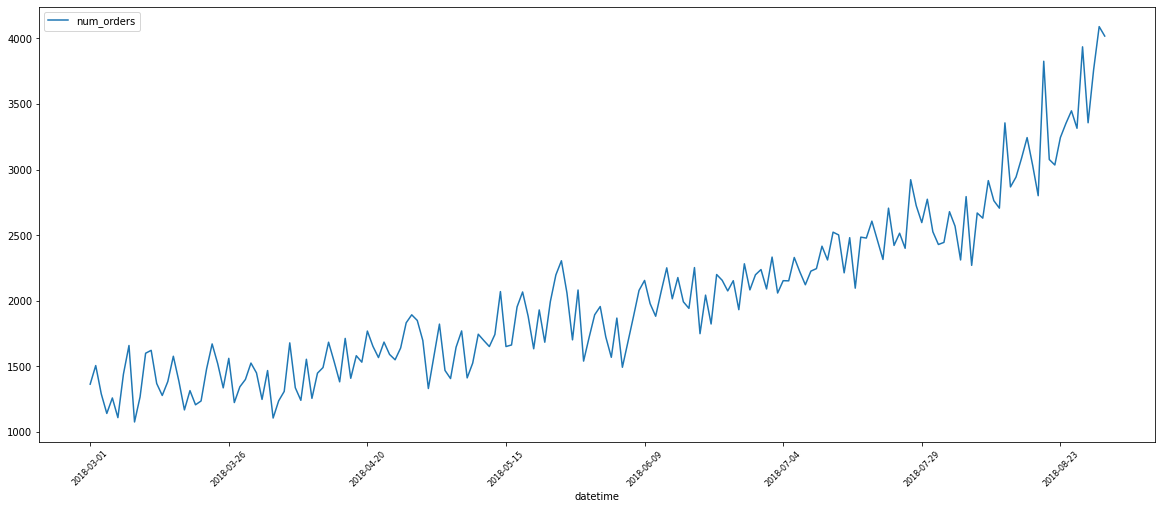

In [33]:
taxi_df = pd.read_csv('../taxi.csv',parse_dates=True,index_col="datetime")
taxi_df = pd.DataFrame(taxi_df.groupby(taxi_df.index.strftime('%Y-%m-%d')).sum()['num_orders'])
taxi_df.plot(figsize=(20,8))
plt.xticks(rotation = 45,size=8)
plt.show()

In [34]:
main_df = pd.read_csv("../train.csv",index_col = "pickup_datetime")
test_main_df = pd.read_csv("../test.csv",index_col="pickup_datetime")
main_df.index =  pd.to_datetime(main_df.index)
test_main_df.index =  pd.to_datetime(test_main_df.index)
concat_df = pd.DataFrame(main_df.groupby(main_df.index.strftime('%Y-%m-%d %H')).count()['id'])
test_concat_df = pd.DataFrame(test_main_df.groupby(test_main_df.index.strftime('%Y-%m-%d %H')).count()['id'])

In [35]:
test_main_df = pd.read_csv("../test.csv",index_col="pickup_datetime")
test_main_df.index =  pd.to_datetime(test_main_df.index)
test_concat_df = pd.DataFrame(test_main_df.groupby(test_main_df.index.strftime('%Y-%m-%d %H')).count()['id'])

In [36]:
test_main_df

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
pickup_datetime,,,,,,,,
2016-06-30 23:59:58,id3004672,1,1,-73.988129,40.732029,-73.990173,40.756680,N
2016-06-30 23:59:53,id3505355,1,1,-73.964203,40.679993,-73.959808,40.655403,N
2016-06-30 23:59:47,id1217141,1,1,-73.997437,40.737583,-73.986160,40.729523,N
2016-06-30 23:59:41,id2150126,2,1,-73.956070,40.771900,-73.986427,40.730469,N
2016-06-30 23:59:33,id1598245,1,1,-73.970215,40.761475,-73.961510,40.755890,N
...,...,...,...,...,...,...,...,...
2016-01-01 00:02:52,id3008929,1,1,-74.003464,40.725105,-74.001251,40.733643,N
2016-01-01 00:01:52,id3700764,1,1,-74.006363,40.743782,-73.953407,40.782467,N
2016-01-01 00:01:24,id2568735,1,2,-73.972267,40.759865,-73.876602,40.748665,N


In [37]:
display_df = pd.DataFrame(main_df.groupby(main_df.index.strftime('%Y-%m-%d')).count()['id'])

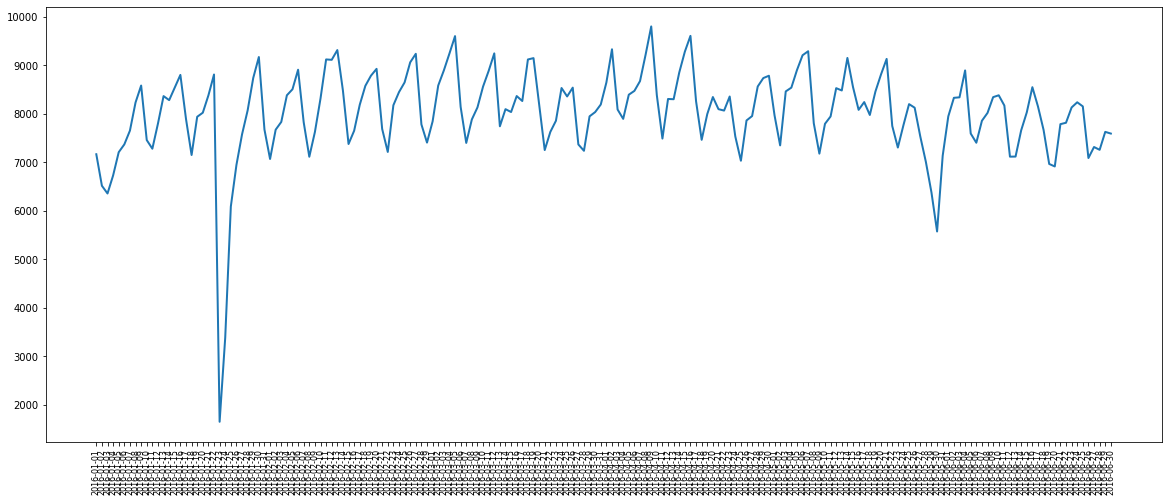

In [38]:
fig = plt.figure(figsize=(20.,8.))
plt.plot(display_df,linewidth=2,animated=True)
plt.xticks(rotation = 90,size=8)
plt.show()

In [39]:
weather_df = pd.read_csv("../weather_data_nyc_centralpark_2016(1).csv")

<AxesSubplot:xlabel='date'>

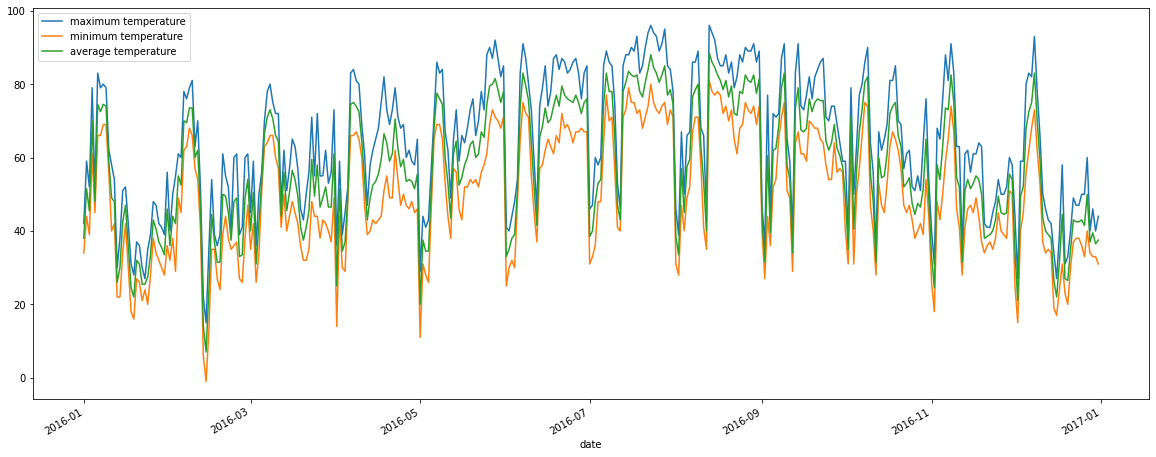

In [42]:
weather_df.date = pd.to_datetime(weather_df.date,'%d-%m-%Y')
weather_df.plot(x="date",kind="line",figsize=(20,8),sharex=True)

In [43]:
another_df = pd.read_csv("../train.csv")
plot_df = another_df[['pickup_datetime','pickup_longitude','pickup_latitude']].copy()
plot_df['day_of_week'] = pd.to_datetime(plot_df['pickup_datetime']).dt.dayofweek
plot_df['hour_of_day'] = pd.to_datetime(plot_df['pickup_datetime']).dt.hour
plot_df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,day_of_week,hour_of_day
0,2016-03-14 17:24:55,-73.982155,40.767937,0,17
1,2016-06-12 00:43:35,-73.980415,40.738564,6,0
2,2016-01-19 11:35:24,-73.979027,40.763939,1,11
3,2016-04-06 19:32:31,-74.010040,40.719971,2,19
4,2016-03-26 13:30:55,-73.973053,40.793209,5,13


### Creating HEATMAP of the demand 

In [92]:
def embed_map(map, filename):
    map.save(filename)
    return IFrame(filename, width='100%', height='500px')
dow_dict = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

def animate():
    for i in range(0, 7):
        for j in range(0, 24):
            # Set file path
            tmpurl=f'file:///H:/zummit/taxi/TaxiDemand/html_maps_pickup/{i}_{j}_heatmap.html'

            # Set browser to Chrome
            browser = webdriver.Chrome()

            # Open file in browser
            browser.get(tmpurl)

            # If hour is < 10, add 0 for sorting purposes and to keep chronological order
            if j < 10:
                browser.save_screenshot(f'./maps_png_pickup/{i}_0{j}_heatmap.png')
            else:
                browser.save_screenshot(f'./maps_png_pickup/{i}_{j}_heatmap.png')

            # Close browser
            browser.quit()
        
def png_to_gif(path_to_images, save_file_path, duration=500):
    frames = []
    
    # Retrieve image files
    images = glob.glob(f'{path_to_images}')
    
    # Loop through image files to open, resize them and append them to frames
    for i in sorted(images): 
        im = Image.open(i)
        im = im.resize((550,389),Image.ANTIALIAS)
        frames.append(im.copy())
        
    # Save frames/ stitched images as .gif
    frames[0].save(f'{save_file_path}', format='GIF', append_images=frames[1:], save_all=True,
                   duration=duration, loop=0)
        
png_to_gif(path_to_images='./maps_png_pickup/*.png', 
           save_file_path='./pickup_heatmap.gif',
           duration=500)

### ARMA type model

In [93]:
# import from files for ar and ma models write theory and stuff 

In [44]:
arma_df = concat_df.id.diff().dropna()
test_arma_df = test_concat_df.id.diff().dropna()

In [45]:
print(f"Dickey Fuller test score : {adfuller(arma_df)[1]}")

Dickey Fuller test score : 2.5910715444942176e-29


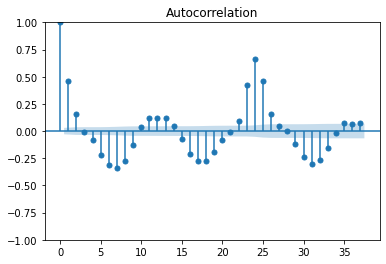

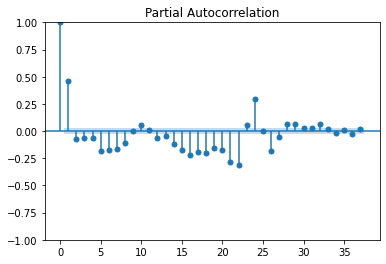

In [46]:
ACF = plot_acf(arma_df.dropna())
PACF = plot_pacf(arma_df.dropna(),method='ywm')

In [69]:
arma_df

pickup_datetime
2016-01-01 01     20.0
2016-01-01 02    -63.0
2016-01-01 03    -24.0
2016-01-01 04   -156.0
2016-01-01 05   -181.0
                 ...  
2016-06-30 19     47.0
2016-06-30 20    -44.0
2016-06-30 21     44.0
2016-06-30 22    -22.0
2016-06-30 23    -39.0
Name: id, Length: 4358, dtype: float64

In [62]:
from ARMA.main import AR,MA,adf_check

In [66]:
def AR(p,df):
    df_temp = df

  #Generating the lagged p terms
    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['id'].shift(i)

    train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
      # df_train_2[['Value','Predicted_Values']].plot()

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_

    RMSE = mean_squared_error(df_test['id'], df_test['Predicted_Values'])

    
    
    return [df_train_2,df_test,theta,intercept,RMSE]



In [75]:
best_RMSE=100000000000
best_p = -1
from tqdm import trange
for i in (w := trange(1,10)):
    [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(arma_df))
    if RMSE < best_RMSE:
        best_p = i
        best_RMSE = RMSE
    w.set_description(f"The RMSE is : {RMSE}, Value of p : {i}")

The RMSE is : 3059.9723470656195, Value of p : 9: 100%|█████████████████| 9/9 [00:00<00:00, 108.48it/s]


In [171]:
model = ARIMA(arma_df,order=(4,1,1))

c:\users\acer\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\acer\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\acer\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [172]:
model_fit = model.fit()

In [173]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     id   No. Observations:                 4358
Model:                 ARIMA(4, 1, 1)   Log Likelihood              -24200.738
Date:                Wed, 18 Jan 2023   AIC                          48413.475
Time:                        14:48:01   BIC                          48451.752
Sample:                             0   HQIC                         48426.985
                               - 4358                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4814      0.011     45.131      0.000       0.461       0.502
ar.L2         -0.0427      0.013     -3.218      0.001      -0.069      -0.017
ar.L3         -0.0308      0.018     -1.695      0.090      -0.066       0.005
ar.L4         -0.0623      0.017     -3.758      0.000      -0.095      -0.030
ma.L1         -0.9999      0.051    -19.448      0.000      -1.101      -0.899
sigma2      3901.7024    196.487     19.857      0.000    3516.596    4286.809
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):              2783.47
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.32
Prob(H) (two-sided):                  0.20   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
test_arma_df


pickup_datetime
2016-01-01 01    69.0
2016-01-01 02   -53.0
2016-01-01 03   -13.0
2016-01-01 04   -98.0
2016-01-01 05   -28.0
                 ... 
2016-06-30 19   -34.0
2016-06-30 20    13.0
2016-06-30 21    34.0
2016-06-30 22   -22.0
2016-06-30 23     1.0
Name: id, Length: 4355, dtype: float64

### NN based model

In [94]:
# import stuff and some results from the thing a

### final remarks and comparisions 

In [95]:
# compare both the models 

### future scope 